# JetgraphDataset v5.1
In this notebook we show the new version of JetgraphDataset, where we build our dataset ***directly from raw data***. 

Thanks to the new pipeline used to build graphs, we have way more control on the dataset settings and graphs' building methods. 

In addition, after first download and preprocessing, this version is much faster, thus making it possible to perform more experiments in shorter time.

**5.1 new features:**
- possibility to exclude graphs with filters before and after applying transforms
- all graphs have now a string id 

### Configure notebook
We first download and install necessary libraries.

In [1]:
# We use a CPU-based installation, but you can vary it easily from the PyG website:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
%%capture
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

🎉🎉🎉  We now have a custom library to manipulate jetgraphs, we can install it from github with:

In [2]:
%%capture
!pip install git+https://github.com/alessiodevoto/jetgraphs.git

### Download dataset 
The dataset mechanics are slightly different from other versions. 


#### 1. Define strategy to build edges
In order to have full control over the edges, we use our custom transform `jetgraphs.transforms.BuildEdges`. 
Through this, we can decide:

- `directed`: if the dataset should be directed
- `same_layer_threshold`: what is the maximum same layer distance to connect two nodes
- `consecutive_layer_threshold`: what is the maximum consecutive layer distance to connect two nodes
- `self_loop_weight`: what edge attribute to assign to self loops.
- `distance_p`: how should the distance between two nodes be computed? {1=manhattan, 2=euclidean}

Thanks to this transform, it's now easy to decide the graph building policy and test different settings, for instance the edge thresholds.

In [3]:
from jetgraphs.transforms import BuildEdges

edge_builder = BuildEdges(
    directed=False, 
    self_loop_weight=1,
    same_layer_threshold=0.6, 
    consecutive_layer_threshold=0.6,
    distance_p=2)

#### 2. 🆕 🛑 Add optional transforms and filters (new feature)

We can now use filters during the processing of graphs. A filter is a boolean class that, given a graph, returns True if that graph should be included in the dataset, else False. We apply filters at two stages: before **pre_transform** and before **transform**, like shown in image here. 

Filter are the best way to exclude graphs based on their number of nodes. Graphs are filtered and pre transformed at processing stage. `pre_filter`, `pre_transform`, `post_filter` and `transform` are all provided as arguments to JetGraphDataset class.

Filters are found in `jetgraphs.transforms`.

![](https://drive.google.com/uc?export=view&id=1QHc4hJlZGm3xI5NlRs3Ci0Fz2sOAgqoS)



In [4]:
from jetgraphs.transforms import GraphFilter 

graph_filter = GraphFilter(min_num_nodes=3) # only graphs with at least 3 nodes will be accepted

Optionally, we can also add other transforms. All transforms are found in `jetgraphs.transforms`.

Here we just use `NumLayers` and `LayersNum`, that respectively add to each data object the number of layers and the ids of layers (e.g. [1,4] ) found in that graph.

In [5]:
from torch_geometric.transforms import Compose 
from jetgraphs.transforms import NumLayers, LayersNum

optional_transforms = Compose([NumLayers(), LayersNum()])

#### 3. Download dataset
🛑 Remark: After the inital download and preprocessing (this url is slower than the others), a saved preprocessed version is kept on disk, so that any further processing will be much quicker.


We can download and build the dataset like so:


In [ ]:
!rm -rf /content/jetgraph_dataset

In [6]:
from jetgraphs.JetGraphDataset import JetGraphDatasetInMemory_v2

datasets_root = "/content/jetgraphdataset"
raw_data_url = "<secret url>"

jet_graph_dataset = JetGraphDatasetInMemory_v2(
    root = datasets_root,           # directory where to download data 
    url = raw_data_url,             # url to raw data
    subset = '0.5%',                # which subset of the intial 100k graph to consider, default is 100%
    pre_filter = graph_filter,      
    pre_transform = edge_builder,   # edge_builder should be passed as pre_transform to keep data on disk.
    post_filter = graph_filter,
    transform = optional_transforms,
    ) 

Downloading...


Moving Directories to raw directory...
Renaming files...
Done renaming files!
[Preprocessing] Preprocessing data to build dataset of graphs without edges.
['/content/jetgraphdataset/raw/Signal_v6', '/content/jetgraphdataset/raw/Background3_v6', '/content/jetgraphdataset/raw/Background2_v6']
[Preprocessing] Reading files in /content/jetgraphdataset/raw/Signal_v6...


Processing...


[Preprocessing] Building graphs...


100%|██████████| 49999/49999 [00:11<00:00, 4313.58it/s]


[Preprocessing] Done preprocessing files in /content/jetgraphdataset/raw/Signal_v6
[Preprocessing] Reading files in /content/jetgraphdataset/raw/Background3_v6...
[Preprocessing] Building graphs...


100%|██████████| 24999/24999 [00:07<00:00, 3359.02it/s]


[Preprocessing] Done preprocessing files in /content/jetgraphdataset/raw/Background3_v6
[Preprocessing] Reading files in /content/jetgraphdataset/raw/Background2_v6...
[Preprocessing] Building graphs...


100%|██████████| 24999/24999 [00:07<00:00, 3343.03it/s]


[Preprocessing] Done preprocessing files in /content/jetgraphdataset/raw/Background2_v6
[Preprocessing] Done preprocessing all subdirectories!
[Processing] Loading preprocessed data...
[Processing] Selecting 500 graphs from the initial 100000.
[Processing] Graphs will be 125 from Background 0, 125 from Background 1, and 250 from Signal subdir.
[Processing] Pre-filtering out unwanted graphs...


100%|██████████| 500/500 [00:00<00:00, 393535.75it/s]


[Processing] Applying pre transform...


100%|██████████| 486/486 [00:01<00:00, 382.54it/s]


[Processing] Post-filtering out unwanted graphs...


100%|██████████| 486/486 [00:00<00:00, 240522.92it/s]


Loaded dataset containing subset of 0.5%


Done!


In [10]:
# now graphs have a unique id, assigned only once before any other operation is performed
# ids are the same across different versions of datasets
jet_graph_dataset[100]

Data(x=[5, 4], y=[1], id='106', edge_attr=[21, 1], edge_index=[2, 21], num_layers=3, layers_num='[0, 1, 2]')

In [11]:
# only 486 graphs out of the initial 500 have been accepted
jet_graph_dataset

JetGraphDatasetInMemory_v2(486)

#### 4. New graph plotting function
The new function to plot a single graph offers a lot of new features. 
Most important are:
- we can control the angle and elevation of the plot (i.e. change the point of view) (`elev` and `angle`)
- we can decide whether higher energy nodes should be bigger in the plot (`energy_is_size`) 
- we can draw nodes belonging to differnt layers in different colors `color_layers`


In [23]:
g = jet_graph_dataset[50]
g

Data(x=[9, 4], y=[1], id='56', edge_attr=[57, 1], edge_index=[2, 57], num_layers=4, layers_num='[0, 1, 2, 3]')

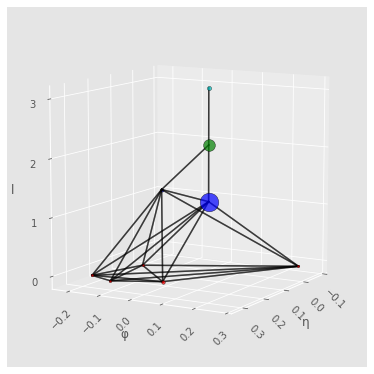

In [24]:
from jetgraphs.utils import plot_jet_graph

plot_jet_graph(
    g, 
    angle=30, 
    elev=10, 
    color_layers=True, 
    energy_is_size=True,  
    save_to_path=False)

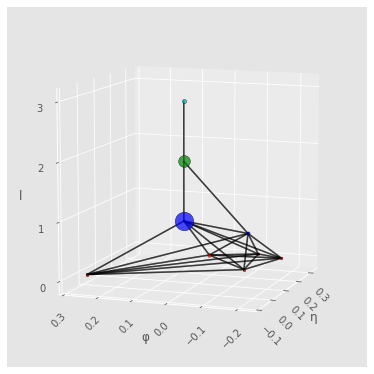

In [25]:
plot_jet_graph(
    g, 
    angle=200, 
    elev=10, 
    color_layers=True, 
    energy_is_size=True,  
    save_to_path=False)

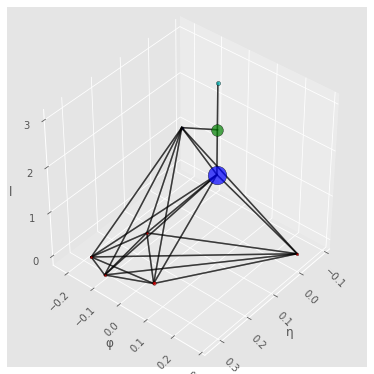

In [26]:
plot_jet_graph(
    g, 
    angle=40, 
    elev=40, 
    color_layers=True, 
    energy_is_size=True,  
    save_to_path=False)

#### 5. Export dataset to pandas and plot overall statistics 
We also have new tools for analysing the dataset in Pandas format automatically.  
We can export the dataset to pandas thanks to `jetgraphs.utils.stats_to_pandas` and then plot info with `jetgraphs.utils.plot_dataset_info2`


In [ ]:
from jetgraphs.utils import stats_to_pandas

df = stats_to_pandas(
    jet_graph_dataset, 
    # include fields of Data objects that were added by transforms
    additional_col_names=['layers_num', 'num_layers'] 
    )
df

,class,num_nodes,num_edges,layers_num,num_layers
0,1,5,13,"[0, 2]",2
1,1,5,17,"[0, 1, 3]",3
2,1,5,19,"[0, 1, 2]",3
3,1,6,36,[0],1
4,1,2,2,"[0, 2]",2
...,...,...,...,...,...
99995,0,7,25,"[0, 1, 2]",3
99996,0,6,24,"[0, 1, 2]",3
99997,0,12,122,"[0, 1, 2]",3
99998,0,11,83,"[0, 1, 2]",3


We also have some utils to plot dataset features. 

Creating plots for columns: ['class', 'num_nodes', 'num_edges', 'layers_num', 'num_layers'] from dataset with columns: ['class', 'num_nodes', 'num_edges', 'layers_num', 'num_layers'])


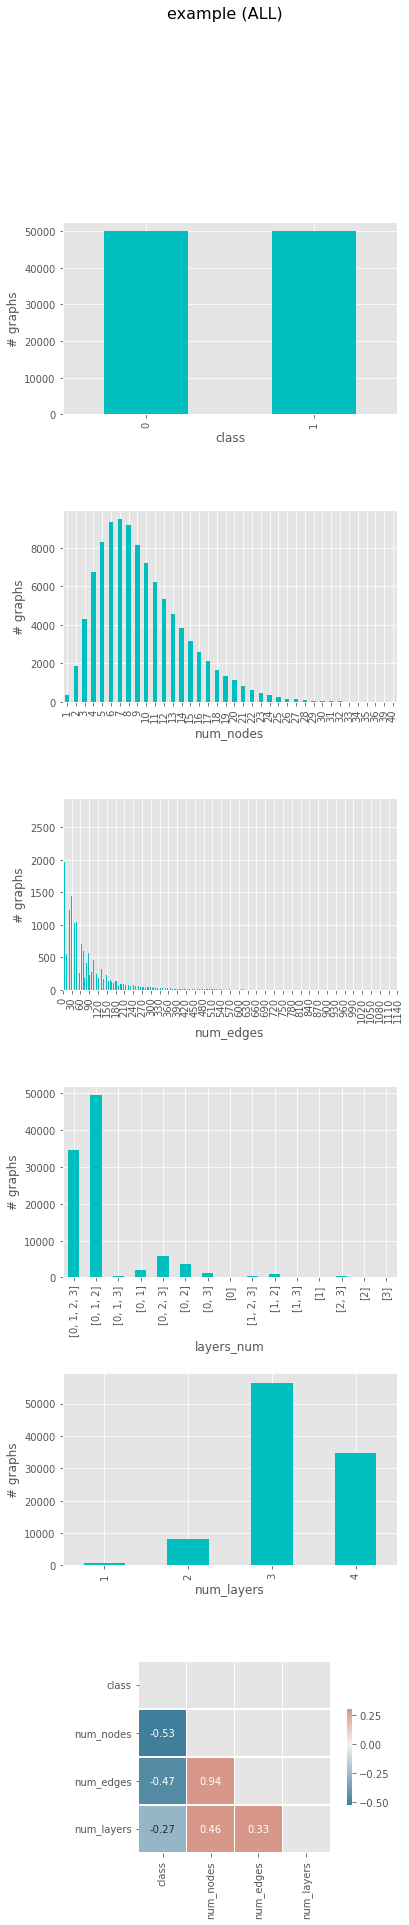

In [ ]:
from jetgraphs.utils import plot_dataset_info2

plot_dataset_info2(df, 
                   title='example',
                   include_cols=False,
                   exclude_cols=False,
                   separate_classes=False,
                   save_to_path=False
                   )

Creating plots for columns: ['class', 'num_nodes', 'num_edges', 'layers_num', 'num_layers'] from dataset with columns: ['class', 'num_nodes', 'num_edges', 'layers_num', 'num_layers'])


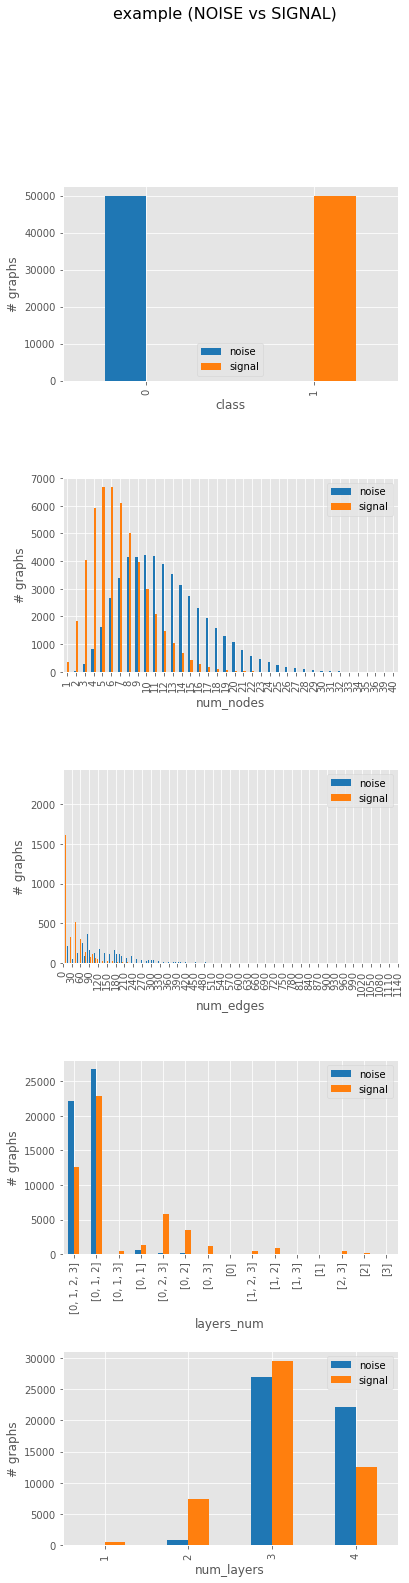

In [ ]:
plot_dataset_info2(df, 
                   title='example',
                   include_cols=False, 
                   exclude_cols=False, # in case we want to exclude, say, the class graph
                   separate_classes=True,
                   save_to_path=False
                   )

## Advanced filtering example

Just to provide and example, here is a scenario where we want to pre and post filter graphs.



In [29]:
# remove the preprocessed dataset as we will provide other arguments now
!rm -rf /content/jetgraphdataset/processed

In [32]:
from torch_geometric.transforms import Compose, LargestConnectedComponents 
from jetgraphs.transforms import NumLayers, LayersNum 

datasets_root = "/content/jetgraphdataset"
raw_data_url = "<secret url>"

# transforms
custom_transforms = Compose([
    edge_builder,   # build edges same as before
    LargestConnectedComponents() # extract main subgraph
    ])

# only graphs with at least 3 nodes will be accepted
graph_filter = GraphFilter(min_num_nodes=5) 

jet_graph_dataset = JetGraphDatasetInMemory_v2(
    root = datasets_root,               # directory where to download data 
    url = raw_data_url,                 # url to raw data
    subset = '0.5%',                    # which subset of the intial 100k graph to consider, default is 100%
    pre_filter = graph_filter,          # filter out graphs before building edges
    pre_transform = custom_transforms,  # edge_builder should be passed as pre_transform to keep data on disk.
    post_filter = graph_filter,         # filter out graphs after building edges
    transform = optional_transforms,    # final optional transforms
    ) 

Loaded dataset containing subset of 0.5%
The loaded dataset has different settings from the ones requested. Processing graphs again.
[Processing] Loading preprocessed data...
[Processing] Selecting 500 graphs from the initial 100000.
[Processing] Graphs will be 125 from Background 0, 125 from Background 1, and 250 from Signal subdir.
[Processing] Pre-filtering out unwanted graphs...


100%|██████████| 500/500 [00:00<00:00, 211812.14it/s]


[Processing] Applying pre transform...


100%|██████████| 438/438 [00:01<00:00, 319.92it/s]


[Processing] Post-filtering out unwanted graphs...


100%|██████████| 438/438 [00:00<00:00, 141066.20it/s]


In [33]:
# only 411 graphs left
jet_graph_dataset

JetGraphDatasetInMemory_v2(411)

Visualization of what could happen in this pipeline (we were discussing this scenario in last call):

![](https://drive.google.com/uc?export=view&id=1dt1dWm80-RaptjjYVgPeA5cnrL5W-itF)